In [1]:
import sys
sys.path.append('../')
# import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
# import torch
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import r2_score
from tqdm import tqdm
import pandas as pd
# import skdim
from src.comparison.point_clouds import generate_point_cloud
from src.comparison.curvature import compute_sectional_curvature
from src.comparison.abby_curvature import scalar_curvature_est
from src.comparison.diffusion_curvature import diffusion_curvature


In [38]:
def compute_curvatures(point_cloud, gt_curvature, epsilon_PCA=0.2, tau_radius=1, max_min_num=100):
    gt_curvature = np.array(gt_curvature)
    num_eval = int(len(point_cloud))
    our_curvature = []
    for i in tqdm(range(num_eval)):
        b = compute_sectional_curvature(point_cloud, point_cloud[i].reshape(1, -1), 
                                        epsilon_PCA =epsilon_PCA, tau_radius=tau_radius, max_min_num=max_min_num)
        our_curvature.append(b)
    our_curvature = np.array(our_curvature)
    n = 2
    sce_point_cloud = scalar_curvature_est(n, point_cloud)
    ab_curvature = sce_point_cloud.estimate(rmax=np.pi/2)
    ab_curvature = np.array(ab_curvature)
    dc_curvature = diffusion_curvature(point_cloud)
    return dict(
        gt_curvature=gt_curvature,
        our_curvature=our_curvature,
        ab_curvature=ab_curvature,
        dc_curvature=dc_curvature
    )

In [25]:
def plot_curvatures(point_cloud, curvature_dict, save=False, save_path='comparison.pdf'):
    gt_curvature, our_curvature, ab_curvature, dc_curvature = curvature_dict['gt_curvature'], curvature_dict['our_curvature'], curvature_dict['ab_curvature'], curvature_dict['dc_curvature']
    fig = plt.figure(figsize=(12, 3))
    v = our_curvature
    ax1 = fig.add_subplot(141, projection='3d')
    scatter = ax1.scatter(point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2], s=0.5, c=v)
    ax1.set_aspect('equal')
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_zticks([])
    ax1.set_title("ours")
    fig.colorbar(scatter, ax=ax1, shrink=0.5)

    v = dc_curvature
    ax2 = fig.add_subplot(142, projection='3d')
    scatter = ax2.scatter(point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2], s=0.5, c=v)
    ax2.set_aspect('equal')
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_zticks([])
    ax2.set_title("Diffusion Curvature")
    fig.colorbar(scatter, ax=ax2, shrink=0.5)

    v = ab_curvature
    ax3 = fig.add_subplot(143, projection='3d')
    scatter = ax3.scatter(point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2], s=0.5, c=v)
    ax3.set_aspect('equal')
    ax3.set_xticks([])
    ax3.set_yticks([])
    ax3.set_zticks([])
    ax3.set_title("Hickok et. al.")
    fig.colorbar(scatter, ax=ax3, shrink=0.5)

    v = gt_curvature
    ax4 = fig.add_subplot(144, projection='3d')
    scatter = ax4.scatter(point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2], s=0.5, c=v)
    ax4.set_aspect('equal')
    ax4.set_xticks([])
    ax4.set_yticks([])
    ax4.set_zticks([])
    ax4.set_title("Ground Truth curvature")
    fig.colorbar(scatter, ax=ax4, shrink=0.5)

    plt.tight_layout()
    if save:
        plt.savefig(save_path, dpi=300)
    plt.show()

In [26]:
def compare_metrics(curvature_dict):
    gt_curvature, our_curvature, ab_curvature, dc_curvature = curvature_dict['gt_curvature'], curvature_dict['our_curvature'], curvature_dict['ab_curvature'], curvature_dict['dc_curvature']
    corr_dict = dict(
        our=np.corrcoef(our_curvature, gt_curvature)[0, 1],
        ab=np.corrcoef(ab_curvature, gt_curvature)[0, 1],
        dc=np.corrcoef(dc_curvature, gt_curvature)[0, 1]
    )
    mse_dict = dict(
        our=np.sqrt(np.mean((our_curvature - gt_curvature)**2)),
        ab=np.sqrt(np.mean((ab_curvature - gt_curvature)**2)),
        dc=np.sqrt(np.mean((dc_curvature - gt_curvature)**2))
    )
    r2_dict = dict(
        our=r2_score(gt_curvature, our_curvature),
        ab=r2_score(gt_curvature, ab_curvature),
        dc=r2_score(gt_curvature, dc_curvature)
    )
    result_df = pd.DataFrame([corr_dict, mse_dict, r2_dict], index=['corrcoef', 'rmse', 'R2'])
    return result_df

In [39]:
def do_experiment(manifold_type, save, save_path, noise=0.0, **kwargs):
    point_cloud, gt_curvature = generate_point_cloud(
        a=1.5,
        b=0.9,
        c=0.9, 
        r=0.375, 
        R=1, 
        manifold_type=manifold_type, 
        num_points=5000, 
        seed=42
    )
    np.random.seed(42)
    point_cloud += np.random.normal(0, noise, point_cloud.shape)
    res_dict = compute_curvatures(point_cloud, gt_curvature, **kwargs)
    plot_curvatures(point_cloud, res_dict, save=save, save_path=f"{save_path}/plot.pdf")
    res_df = compare_metrics(res_dict)
    if save:
        res_df.to_csv(f"{save_path}/metrics.csv")
    return res_df

100%|██████████| 5000/5000 [01:25<00:00, 58.42it/s]


computed Rdist
computed density
computed nearest neighbor matrices
Running MAGIC on 5000 cells and 3 genes.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.07 seconds.
  Calculating affinities...
  Calculated affinities in 0.10 seconds.
Calculated graph and diffusion operator in 0.21 seconds.


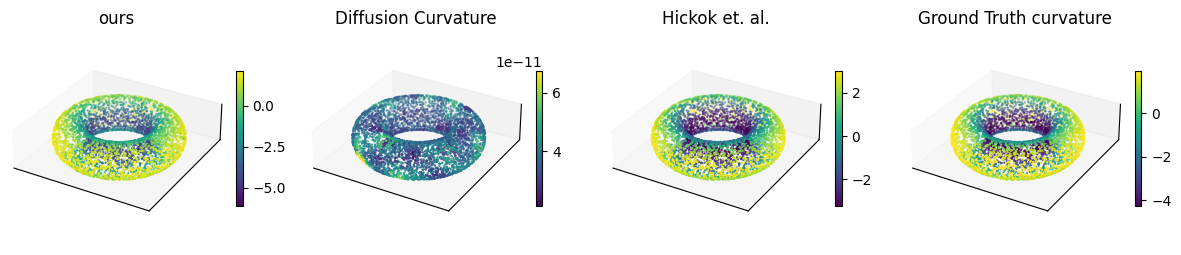

,our,ab,dc
corrcoef,0.994699,0.994832,0.444764
rmse,0.256505,0.752915,2.268979
R2,0.986174,0.880878,-0.081836


In [41]:
do_experiment('torus', False, '', noise=0., max_min_num=120)

100%|██████████| 5000/5000 [01:45<00:00, 47.22it/s]


computed Rdist
computed density
computed nearest neighbor matrices
Running MAGIC on 5000 cells and 3 genes.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.06 seconds.
  Calculating affinities...
  Calculated affinities in 0.10 seconds.
Calculated graph and diffusion operator in 0.19 seconds.


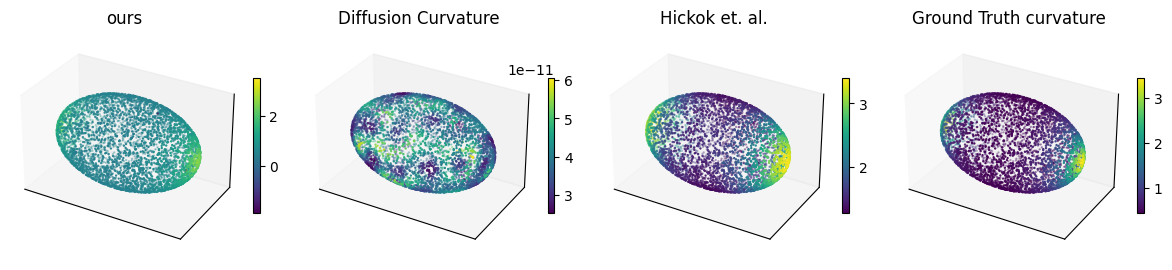

,our,ab,dc
corrcoef,0.974183,0.948243,-0.149454
rmse,0.274052,1.051976,1.133516
R2,0.824405,-1.587377,-2.004023


In [35]:
do_experiment('ellipsoid', False, '', noise=0.)

100%|██████████| 5000/5000 [00:38<00:00, 130.70it/s]


computed Rdist
computed density
computed nearest neighbor matrices
Running MAGIC on 5000 cells and 3 genes.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.07 seconds.
  Calculating affinities...
  Calculated affinities in 0.11 seconds.
Calculated graph and diffusion operator in 0.22 seconds.


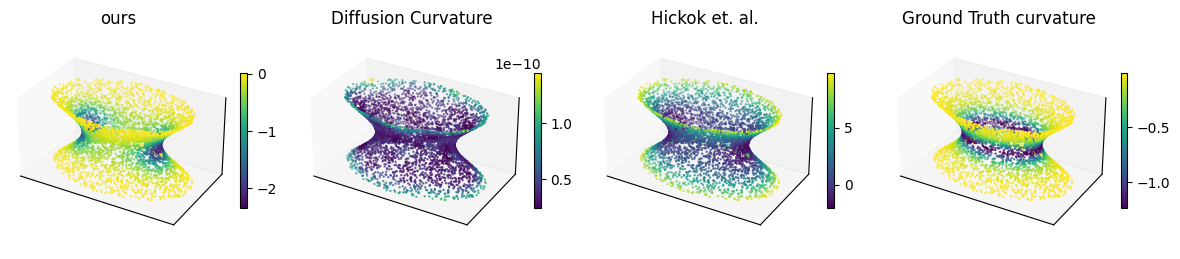

,our,ab,dc
corrcoef,0.720256,0.712922,0.398244
rmse,0.390702,3.954243,0.498247
R2,-0.056951,-107.265639,-0.718914


In [42]:
do_experiment('hyperboloid', False, '', noise=0., epsilon_PCA=0.4, max_min_num=120)

100%|██████████| 5000/5000 [01:27<00:00, 57.41it/s]


computed Rdist
computed density
computed nearest neighbor matrices
Running MAGIC on 5000 cells and 3 genes.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.10 seconds.
  Calculating affinities...
  Calculated affinities in 0.13 seconds.
Calculated graph and diffusion operator in 0.26 seconds.


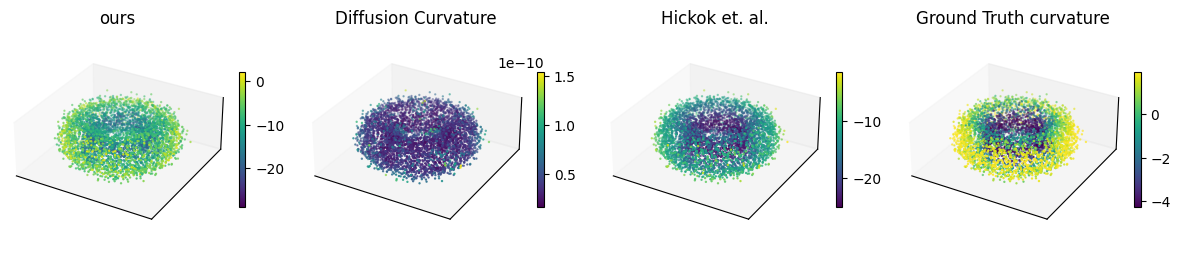

,our,ab,dc
corrcoef,0.751058,0.900682,0.270291
rmse,9.590909,15.775114,2.268979
R2,-18.329483,-51.293262,-0.081836


In [44]:
do_experiment('torus', False, '', noise=0.1, epsilon_PCA=0.4, max_min_num=120)